# Bibliotecas

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.core.display import HTML

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from functools import reduce
import pickle

import warnings
warnings.filterwarnings('ignore')

# Funções auxiliares

In [2]:
def show_null(df):
    null_columns = (df.isnull().sum(axis=0)/len(df)
                    ).sort_values(ascending=False).index

    null_data = pd.concat([df.isnull().sum(axis=0),
                           (df.isnull().sum(axis=0)/len(df)
                            ).sort_values(ascending=False),
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes],
                          axis=1)

    null_data = null_data.rename(columns={0: '#',
                                          1: '% null',
                                          2: 'type'}).sort_values(ascending=False,
                                                                  by='% null')

    return null_data


def plot_num(df, feature):
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(1, 2)
    sns.boxplot(y=feature, data=df, color='firebrick',
                ax=fig.add_subplot(gs[0, 0]))
    plt.ylabel(feature)
    sns.stripplot(y=df[feature], color='darkcyan',
                  ax=fig.add_subplot(gs[0, 1]))
    plt.ylabel(None)
    plt.show()


def plot_cat(df, feature):
    fig = plt.figure(figsize=(12, 8))
    ax = sns.countplot(data=df, x=feature)
    for p in ax.patches:

        ax.annotate(f'\n{p.get_height()}',
                    (p.get_x()+0.4, p.get_height()+5),
                    ha='center',
                    color='black')

    plt.xlabel('\n' + feature)
    plt.ylabel('Quantidade de Clientes')
    plt.show()


def scaler(df):
    df2 = df.copy()
    for column in df2:
        minimo = df2[column].min()
        maximo = df2[column].max()
        df2[column] = (df[column] - minimo)/(maximo - minimo)
    return df2


def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    display(HTML(''))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)


jupyter_settings()

# Carregamento dos dados

In [3]:
df = pd.read_csv('data/marketing_campaign.csv', delimiter='\t')

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


# Descrição dos dados

Coluna | Descrição
-------| --------
ID | Identificador do cliente
Year_Birth | Ano de nascimento do cliente
Education| Nível de escolaridade do cliente
Marital_Status | Estado civil do cliente
Income | Renda familiar anual do cliente
Kidhome | Número de crianças na casa do cliente
Teenhome | Número de adolescentes na casa do cliente
Dt_Customer | Data de inscrição do cliente na empresa
Recency | Número de dias desde a última compra do cliente
Complain| Reclamações do cliente; 1: reclamou nos últimos 2 anos, 0: não reclamou
MntWines | Valor gasto em vinho nos últimos 2 anos
MntFruits | Valor gasto com frutas nos últimos 2 anos
MntMeatProducts | Valor gasto com carne nos últimos 2 anos
MntFishProducts | Valor gasto com pescados nos últimos 2 anos
MntSweetProducts | Valor gasto com doces nos últimos 2 anos
MntGoldProds | Valor gasto em ouro nos últimos 2 anos
AcceptedCmp1 | 1: cliente aceitou a oferta de promoção na 1ª campanha, 0: não aceitou
AcceptedCmp2 | 1: cliente aceitou a oferta de promoção na 2ª campanha, 0: não aceitou
AcceptedCmp3 | 1: cliente aceitou a oferta de promoção na 3ª campanha, 0: não aceitou
AcceptedCmp4 | 1: cliente aceitou a oferta de promoção na 4ª campanha, 0: não aceitou
AcceptedCmp5 | 1: cliente aceitou a oferta de promoção na 1ª campanha, 0: não aceitoupromoção
Response | 1: cliente aceitou a oferta de promoção na última campanha, 0: não aceitou
NumDealsPurchases | Nº de compras feitas com desconto
NumCatalogPurchases | Nº de compras feitas por catálogo
NumStorePurchases | Nº de compras feitas diretamente nas lojas
NumWebPurchases | Nº de compras feitas através do site da empresa
NumWebVisitsMonth | Nº de visitas ao site da empresa no último mês

# Inspeção dos dados

Verificando o nome das colunas.

In [7]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

Verificando a dimensionalidade dos dados.

In [8]:
print(f'Nº de linhas: {df.shape[0]}')
print(f'Nº de coluns: {df.shape[1]}')

Nº de linhas: 2240
Nº de coluns: 29


Verificando os tipos de dados.

In [9]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

### Convertendo dos dados

In [10]:
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, dayfirst=True)

### Checando NA.

In [11]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

### Visualizando os dados

In [12]:
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,2225,2226,2227,2228,2229,2230,2231,2232,2233,2234,2235,2236,2237,2238,2239
ID,5524,2174,4141,6182,5324,7446,965,6177,4855,5899,1994,387,2125,8180,2569,...,4749,4478,4201,8720,10084,7004,9817,8080,9432,8372,10870,4001,7270,8235,9405
Year_Birth,1957,1954,1965,1984,1981,1967,1971,1985,1974,1950,1983,1976,1959,1952,1987,...,1968,1979,1962,1978,1972,1984,1970,1986,1977,1974,1967,1946,1981,1956,1954
Education,Graduation,Graduation,Graduation,Graduation,PhD,Master,Graduation,PhD,PhD,PhD,Graduation,Basic,Graduation,Master,Graduation,...,Graduation,Graduation,Graduation,2n Cycle,Graduation,Graduation,Master,Graduation,Graduation,Graduation,Graduation,PhD,Graduation,Master,PhD
Marital_Status,Single,Single,Together,Together,Married,Together,Divorced,Married,Together,Together,Married,Married,Divorced,Divorced,Married,...,Together,Married,Single,Together,Married,Single,Single,Single,Together,Married,Married,Together,Divorced,Together,Married
Income,58138.0,46344.0,71613.0,26646.0,58293.0,62513.0,55635.0,33454.0,30351.0,5648.0,NaN,7500.0,63033.0,59354.0,17323.0,...,58554.0,63777.0,57967.0,NaN,24434.0,11012.0,44802.0,26816.0,666666.0,34421.0,61223.0,64014.0,56981.0,69245.0,52869.0
Kidhome,0,1,0,1,1,0,0,1,1,1,1,0,0,1,0,...,1,1,0,0,2,1,0,0,1,1,0,2,0,0,1
Teenhome,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,...,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1
Dt_Customer,2012-09-04 00:00:00,2014-03-08 00:00:00,2013-08-21 00:00:00,2014-02-10 00:00:00,2014-01-19 00:00:00,2013-09-09 00:00:00,2012-11-13 00:00:00,2013-05-08 00:00:00,2013-06-06 00:00:00,2014-03-13 00:00:00,2013-11-15 00:00:00,2012-11-13 00:00:00,2013-11-15 00:00:00,2013-11-15 00:00:00,2012-10-10 00:00:00,...,2012-09-26 00:00:00,2013-03-24 00:00:00,2013-03-03 00:00:00,2012-08-12 00:00:00,2014-05-18 00:00:00,2013-03-16 00:00:00,2012-08-21 00:00:00,2012-08-17 00:00:00,2013-06-02 00:00:00,2013-07-01 00:00:00,2013-06-13 00:00:00,2014-06-10 00:00:00,2014-01-25 00:00:00,2014-01-24 00:00:00,2012-10-15 00:00:00
Recency,58,38,26,26,94,16,34,32,19,68,11,59,82,53,38,...,55,87,39,53,9,82,71,50,23,81,46,56,91,8,40
MntWines,635,11,426,11,173,520,235,76,14,28,5,6,194,233,3,...,368,457,229,32,3,24,853,5,9,3,709,406,908,428,84


In [13]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [84]:
dados_numericos = df.select_dtypes(include=['int64', 'float64'])

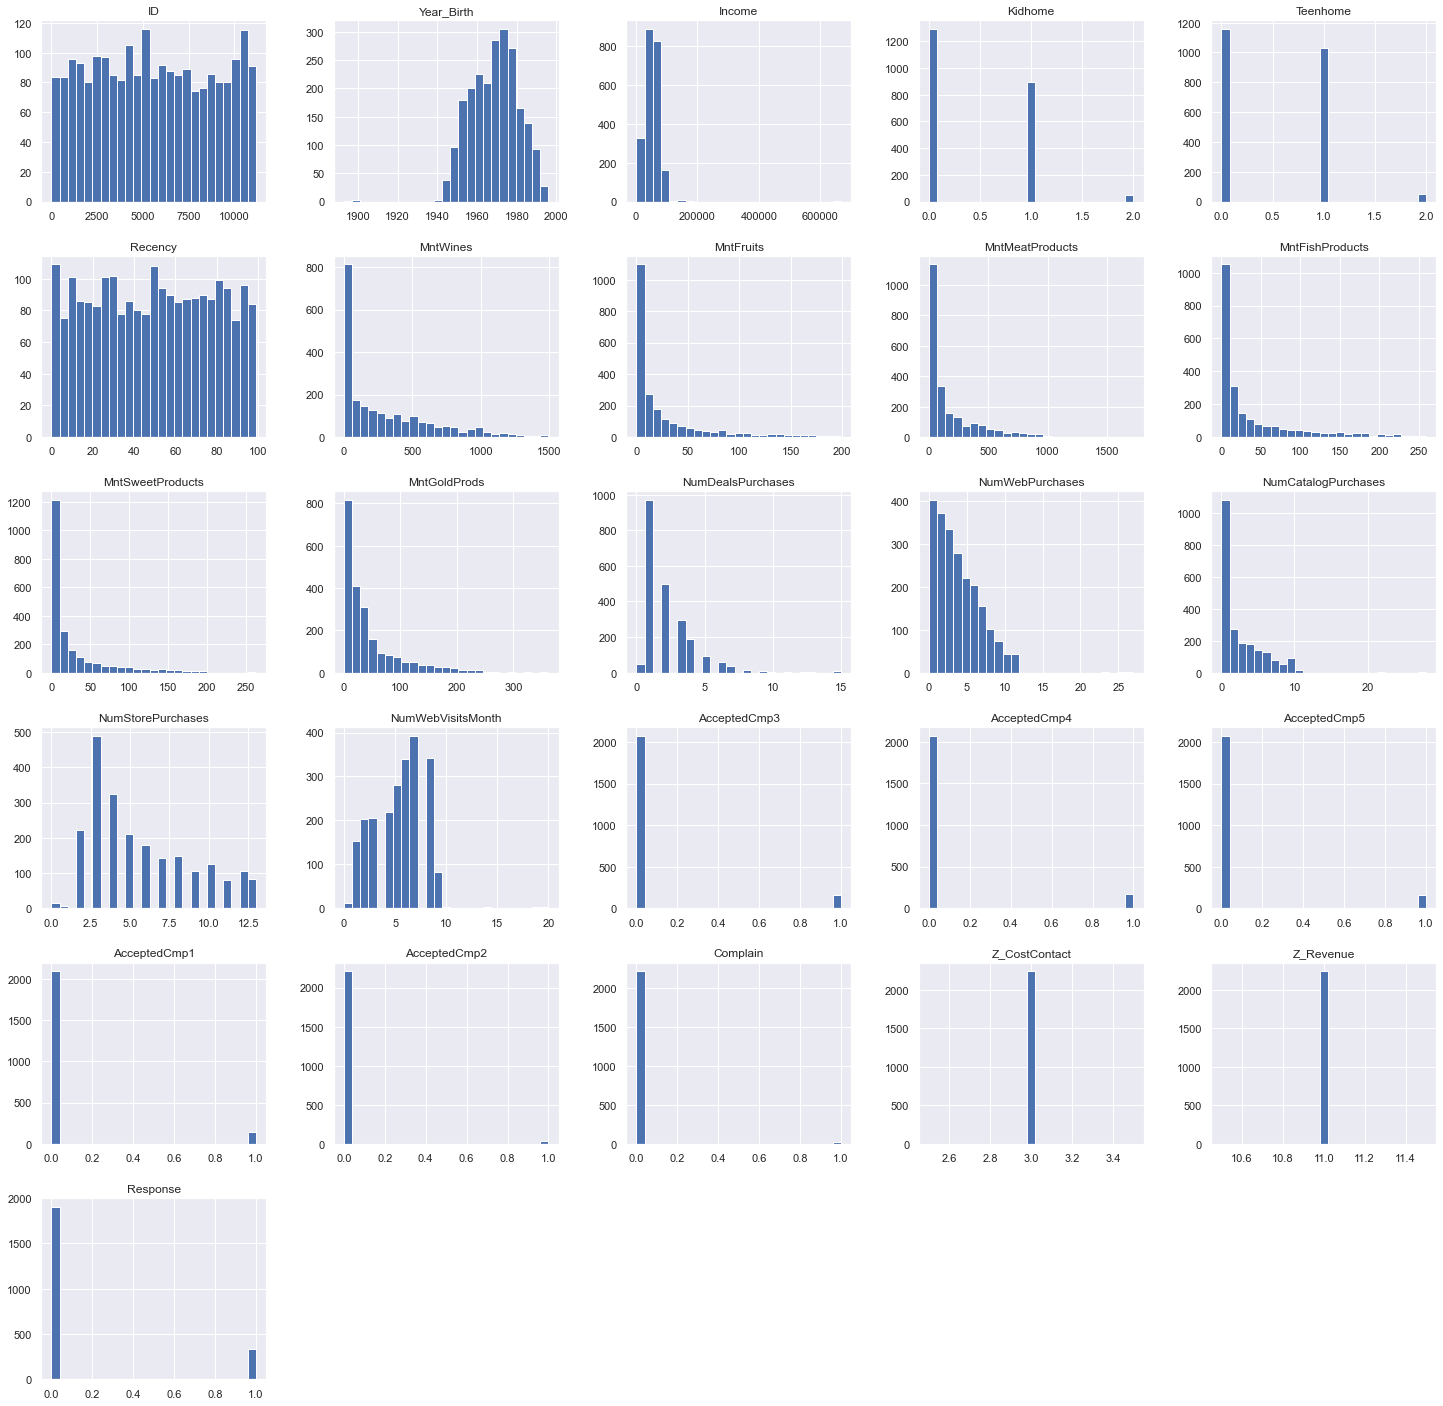

In [15]:
dados_numericos.hist(figsize=(25, 25), bins=25)

# EDA & Features Engineering

O dataset foi separado em: 

- Colunas relacionadas aos clientes → `people` 
- Colunas relacionadas aos produtos → `products`
- Colunas relacionadas às promoções → `promotion`
- Colunas relacionadas ao local de compra → `place`

In [16]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [17]:
# dados dos clientes

people = df[['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
             'Teenhome', 'Dt_Customer', 'Recency', 'Complain']]

# dados dos produtos

products = df[['ID', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
               'MntSweetProducts', 'MntGoldProds']]

# dados das promoções

promotion = df[['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
                'AcceptedCmp5', 'Response']]

# dados de local de compra

place = df[['ID', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
            'NumDealsPurchases', 'NumWebVisitsMonth']]

Variáveis destacadas com `*` correspondem às variáveis novas (Features Engineering).

### Dados dos clientes

#### Income

Mostrando a porcentagem de dados nulos da coluna `Income`.

In [18]:
show_null(people)

,#,% null,type
Income,24,0.010714,float64
ID,0,0.000000,int64
Year_Birth,0,0.000000,int64
Education,0,0.000000,object
Marital_Status,0,0.000000,object
Kidhome,0,0.000000,int64
Teenhome,0,0.000000,int64
Dt_Customer,0,0.000000,datetime64[ns]
Recency,0,0.000000,int64
Complain,0,0.000000,int64


Os dados correspondem a 1%, por esse motivo, foi decidido dropar os dados nulos.

In [19]:
people.dropna(inplace=True)

Verificando e removendo outliers da coluna `Income`.

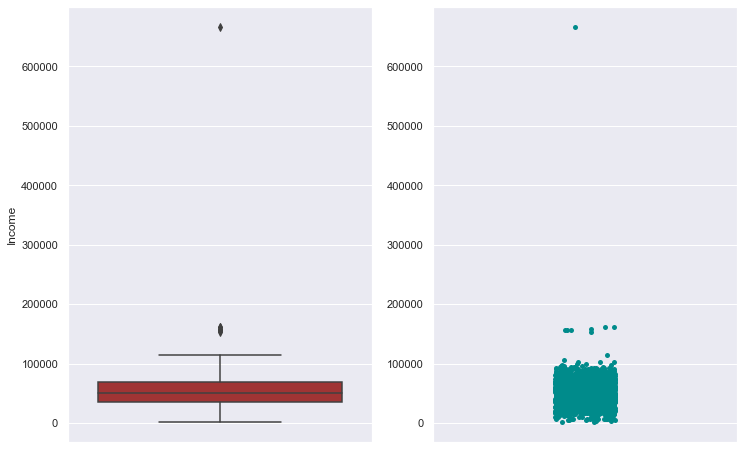

In [20]:
plot_num(people, 'Income')

In [21]:
people = people[people.Income < 200000]

Checando modificações.

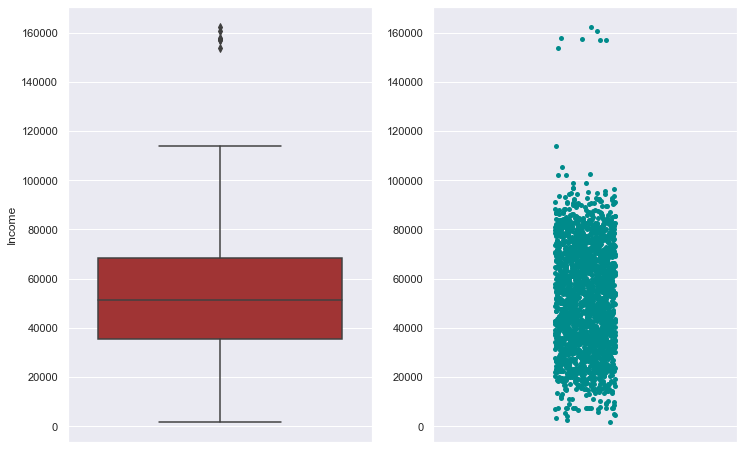

In [22]:
plot_num(people, 'Income')

#### Year_Birth

Verificando e removendo outliers da coluna `Year_Birth`.

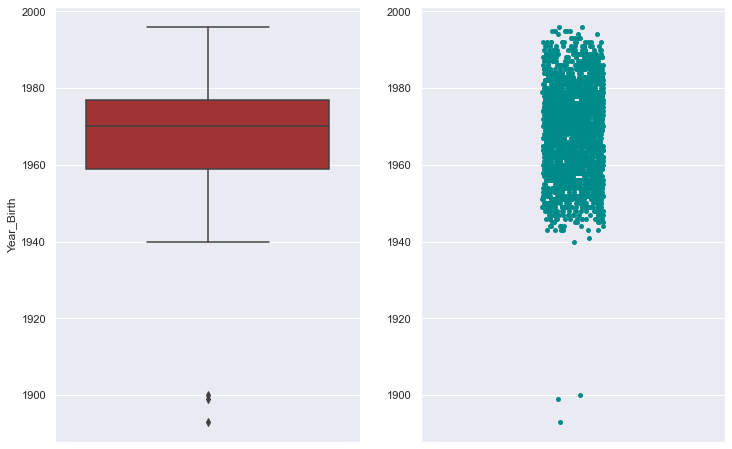

In [23]:
plot_num(people, 'Year_Birth')

In [24]:
people = people[people.Year_Birth > 1930]

Checando modificações.

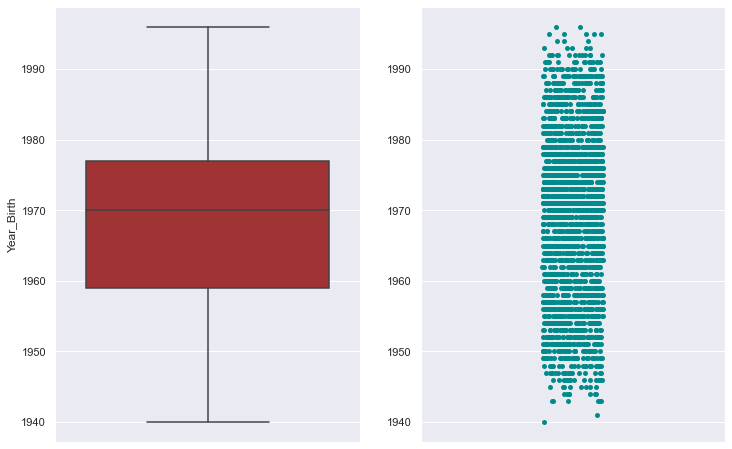

In [25]:
plot_num(people, 'Year_Birth')

#### Education

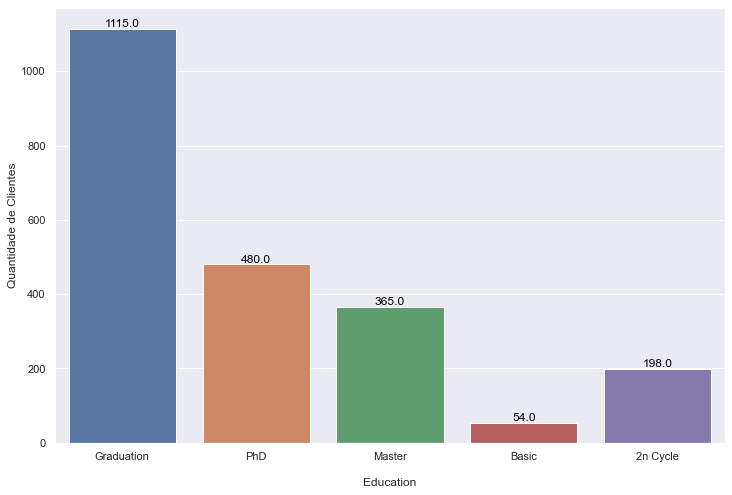

In [26]:
plot_cat(people, 'Education')

Realizando o Encoding do tipo _Ordinal encoding_ na coluna `Education`.

0 - Basic  
1 - 2n Cycle  
2 - Graduation  
3 - Master  
4 - PhD  

In [27]:
people.Education = people.Education.apply(lambda x: 0 if x == 'Basic'
                                          else (1 if x == '2n Cycle'
                                                else (2 if x == 'Graduation'
                                                      else (3 if x == 'Master'
                                                            else (4 if x == 'PhD' else None)))))

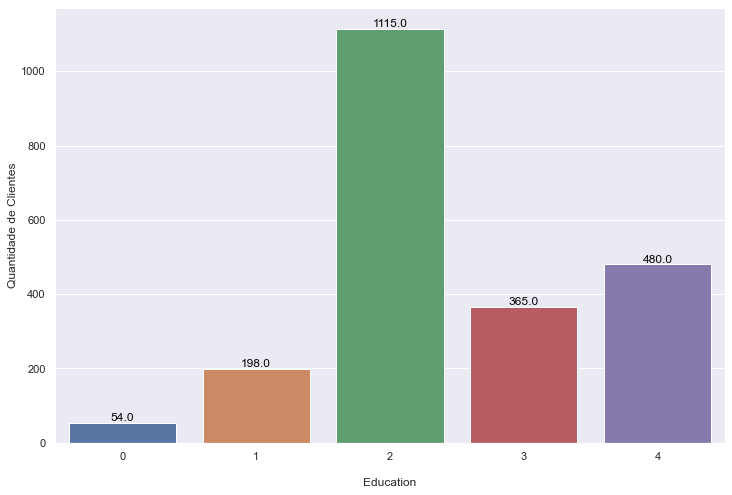

In [28]:
plot_cat(people, 'Education')

#### Marital_Status

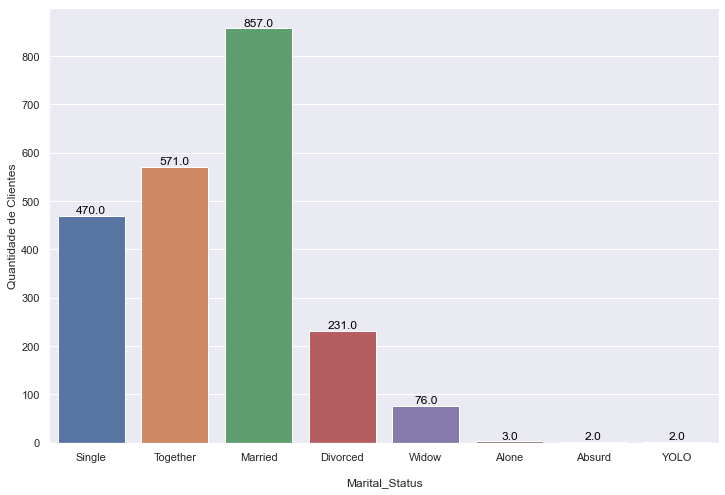

In [29]:
plot_cat(people, 'Marital_Status')

Verificando e uniformizando algumas categorias da variável `Marital_Status`.

In [30]:
people = people[people.Marital_Status != 'Absurd']

In [31]:
people.Marital_Status = people.Marital_Status.apply(lambda x: 'Single' if x == 'Alone'
                                                    else ('Single' if x == 'YOLO' else x))

In [32]:
people.Marital_Status = people.Marital_Status.apply(
    lambda x: 'Together' if x == 'Married' else x)

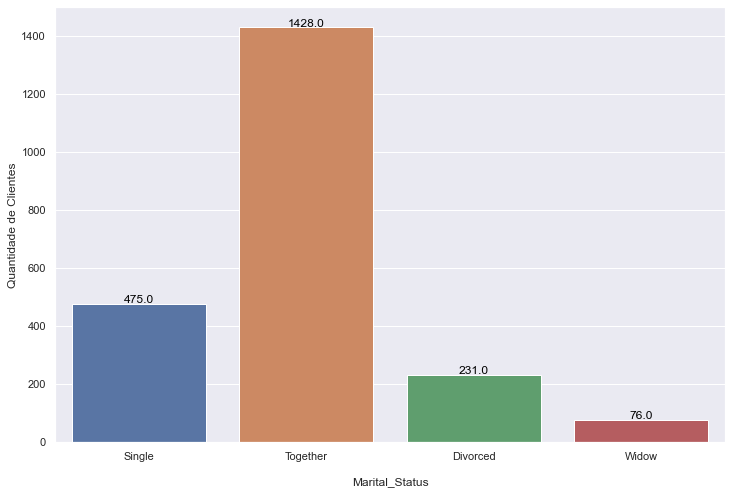

In [33]:
plot_cat(people, 'Marital_Status')

Realizando o Encoding do tipo _One hot encoding_ na coluna `Marital_Status`.

In [34]:
people = pd.get_dummies(people)

In [35]:
people.columns

Index(['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'Complain', 'Marital_Status_Divorced',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow'],
      dtype='object')

#### Kidhome

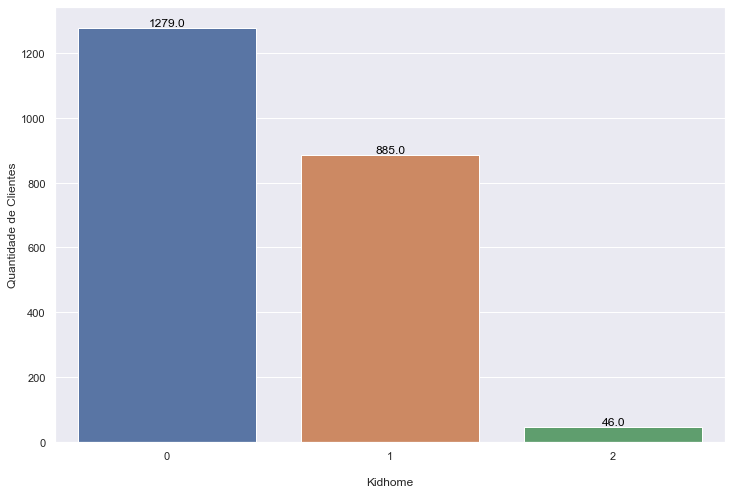

In [36]:
plot_cat(people, 'Kidhome')

#### Teenhome

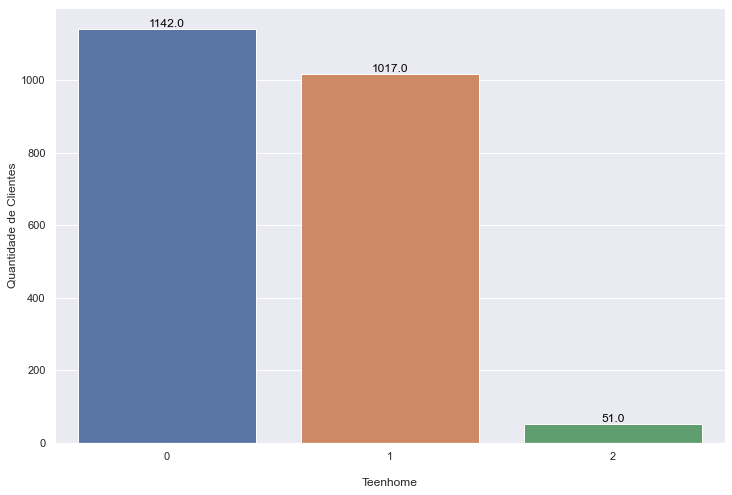

In [37]:
plot_cat(people, 'Teenhome')

#### ChildrenHome *

Somando os dados das colunas `Kidhome` e `Teenhome`  para gerar a coluna nova `ChildrenHome`.

In [38]:
people['ChildrenHome'] = people.Kidhome + people.Teenhome

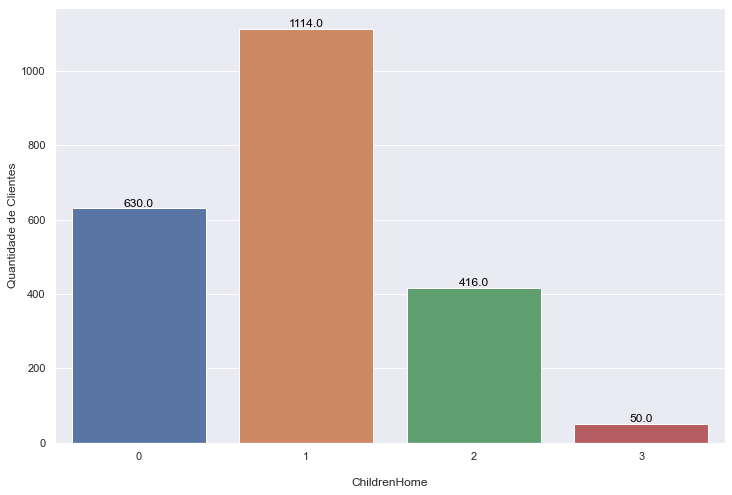

In [39]:
plot_cat(people, 'ChildrenHome')

In [40]:
people.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

#### Dt_Customer

Verificando a `Dt_Customer`, coluna correspondente a data de cadastro do cliente na empresae e a coluna `Recency`, que corresponde ao nº de dias desde a última compra do cliente para definir o tempo de vida do usuário.

`LifeTime`: última data de compra - a data de cadastro inicial.

In [41]:
people.Dt_Customer.min()

Timestamp('2012-07-30 00:00:00')

In [42]:
people.Dt_Customer.max()

Timestamp('2014-06-29 00:00:00')

In [43]:
(people['Dt_Customer'] + pd.to_timedelta(people['Recency'], unit='d')).max()

Timestamp('2014-10-04 00:00:00')

#### LifeTime *

Criando a variável nova `LifeTime`.

In [44]:
people['LifeTime'] = (pd.to_datetime('2014-10-05') -
                      people['Dt_Customer']).dt.days/30

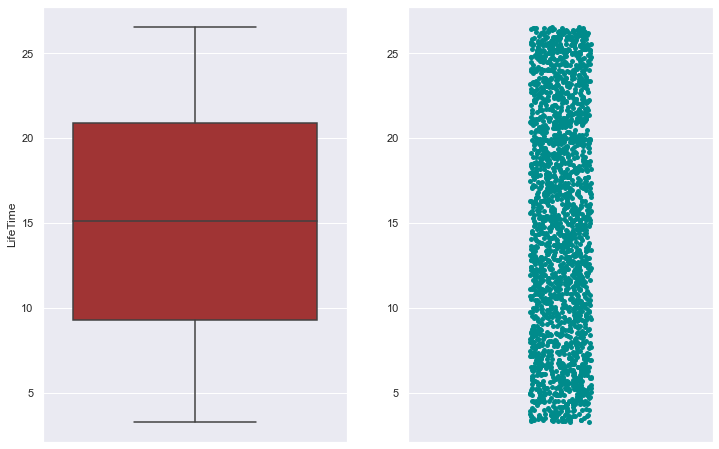

In [45]:
plot_num(people, 'LifeTime')

Excluindo a variável `Dt_Customer`, pois não será utilizada.

In [46]:
people.drop(columns=['Dt_Customer'], inplace=True)

#### Recency

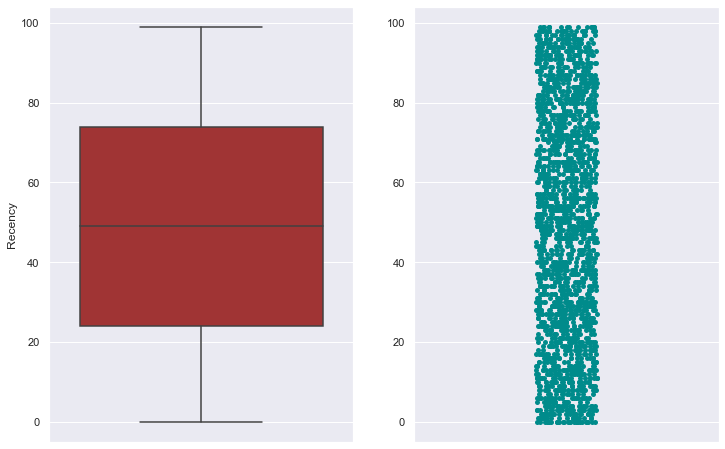

In [47]:
plot_num(people, 'Recency')

#### Complain

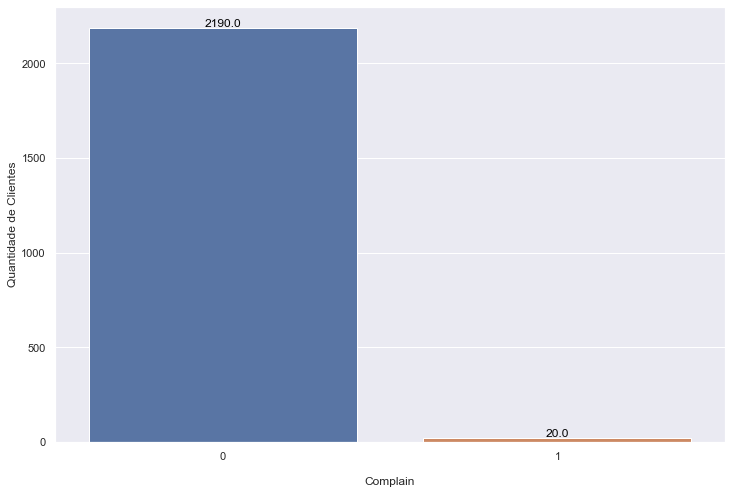

In [48]:
plot_cat(people, 'Complain')

É possível verificar que a variável `Complain` não oferece a variação necessária para gerar clusters, por esse motivo, será excluída.

In [49]:
people.drop(columns=['Complain'], inplace=True)

#### Visão geral das variáveis relacionadas aos clientes

In [50]:
people.head()

,ID,Year_Birth,Education,Income,Recency,Marital_Status_Divorced,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,ChildrenHome,LifeTime
0,5524,1957,2,58138.0,58,0,1,0,0,0,25.366667
1,2174,1954,2,46344.0,38,0,1,0,0,2,7.033333
2,4141,1965,2,71613.0,26,0,0,1,0,0,13.666667
3,6182,1984,2,26646.0,26,0,0,1,0,1,7.900000
4,5324,1981,4,58293.0,94,0,0,1,0,1,8.633333


### Dados dos produtos

####  MntWines

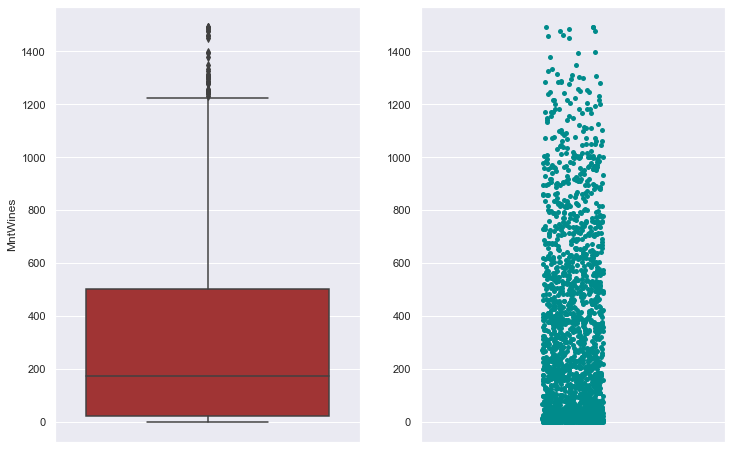

In [51]:
plot_num(products, 'MntWines')

#### MntFruits

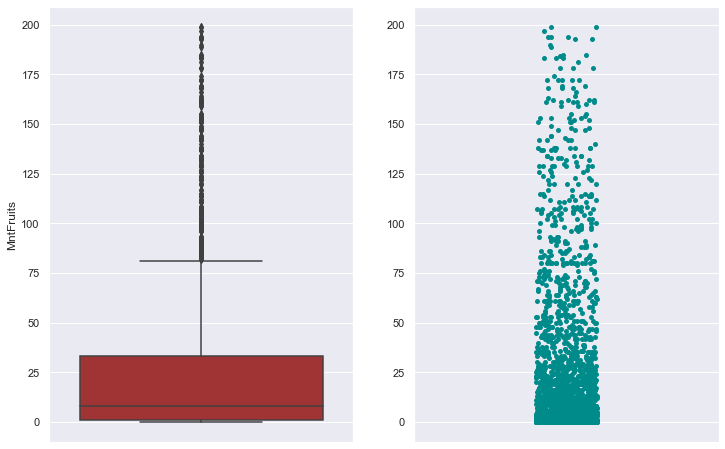

In [52]:
plot_num(products, 'MntFruits')

#### MntMeatProducts

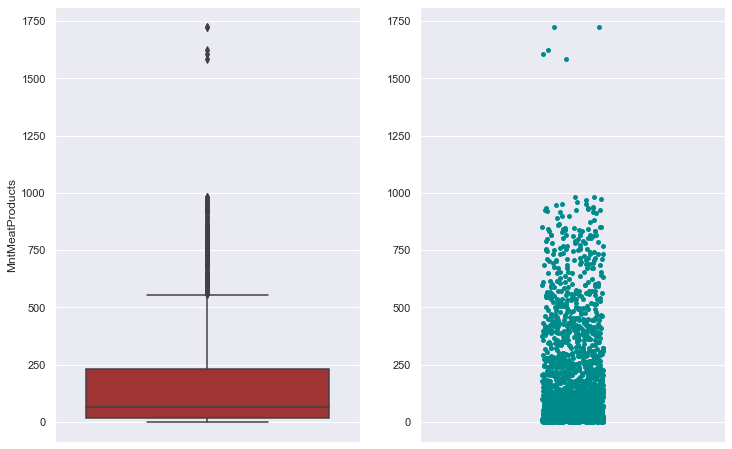

In [53]:
plot_num(products, 'MntMeatProducts')

#### MntFishProducts

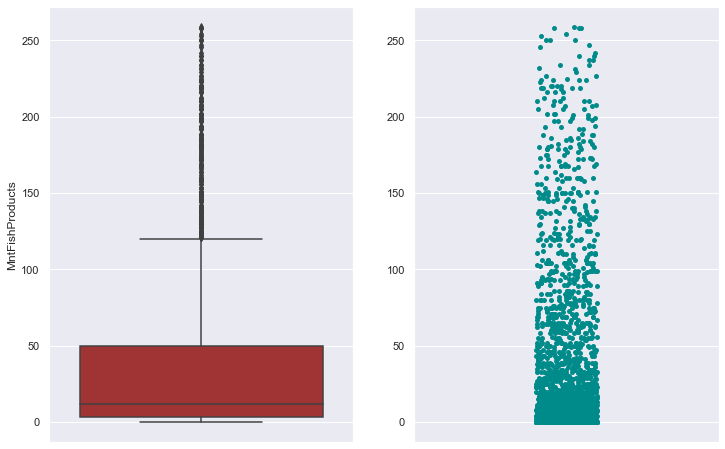

In [54]:
plot_num(products, 'MntFishProducts')

#### MntSweetProducts

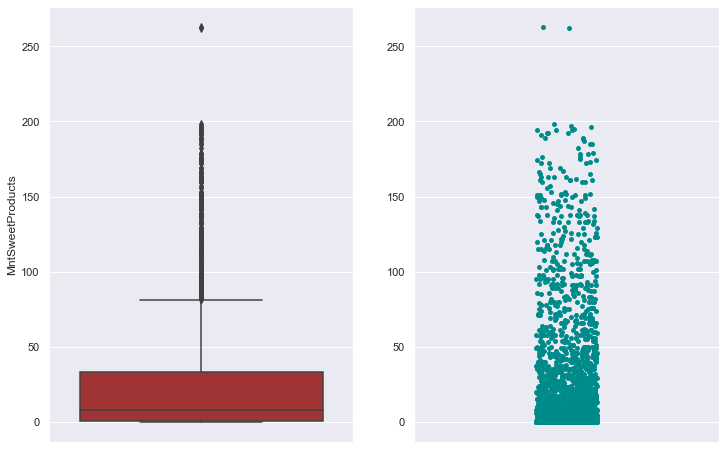

In [55]:
plot_num(products, 'MntSweetProducts')

#### MntGoldProds

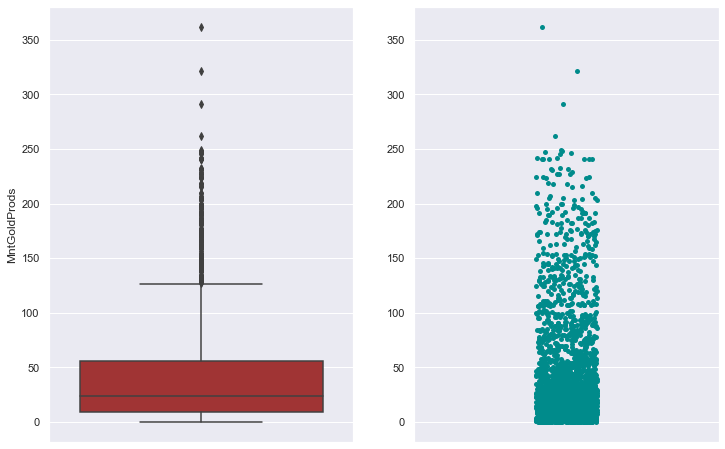

In [56]:
plot_num(products, 'MntGoldProds')

#### TotalAmountSpent *

Criando a coluna `TotalAmountSpent`, correspondente ao total de produtos consumidos.

In [57]:
products['TotalAmountSpent'] = products.MntFishProducts + products.MntFruits + products.MntGoldProds \
    + products.MntMeatProducts + products.MntSweetProducts + products.MntWines

Transformando as variáveis de produtos em porcentagem, resultando na porcentagem de cada categoria.

In [58]:
products.MntFishProducts = products.MntFishProducts / \
    products['TotalAmountSpent']
products.MntFruits = products.MntFruits/products['TotalAmountSpent']
products.MntGoldProds = products.MntGoldProds/products['TotalAmountSpent']
products.MntMeatProducts = products.MntMeatProducts / \
    products['TotalAmountSpent']
products.MntSweetProducts = products.MntSweetProducts / \
    products['TotalAmountSpent']
products.MntWines = products.MntWines/products['TotalAmountSpent']

#### Visão geral das variáveis relacionadas aos produtos

In [59]:
products.head()

,ID,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalAmountSpent
0,5524,0.392703,0.054422,0.337662,0.106370,0.054422,0.054422,1617
1,2174,0.407407,0.037037,0.222222,0.074074,0.037037,0.222222,27
2,4141,0.548969,0.063144,0.163660,0.143041,0.027062,0.054124,776
3,6182,0.207547,0.075472,0.377358,0.188679,0.056604,0.094340,53
4,5324,0.409953,0.101896,0.279621,0.109005,0.063981,0.035545,422


### Dados de promoção

Conferindo se a variável vai de 0 a 1.

In [60]:
promotion.describe()

,ID,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,0.064286,0.013393,0.072768,0.074554,0.072768,0.149107
std,3246.662198,0.245316,0.114976,0.259813,0.262728,0.259813,0.356274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5458.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8427.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### AcceptedCmp *

Criando a coluna `AcceptedCmp`, que corresponde a soma de todas as variáveis de promoção/campanha.

In [61]:
promotion['AcceptedCmp'] = promotion.AcceptedCmp1 + promotion.AcceptedCmp2 + promotion.AcceptedCmp3 + promotion.AcceptedCmp4 + \
    promotion.AcceptedCmp5 + promotion.Response

Checando a distribuição.

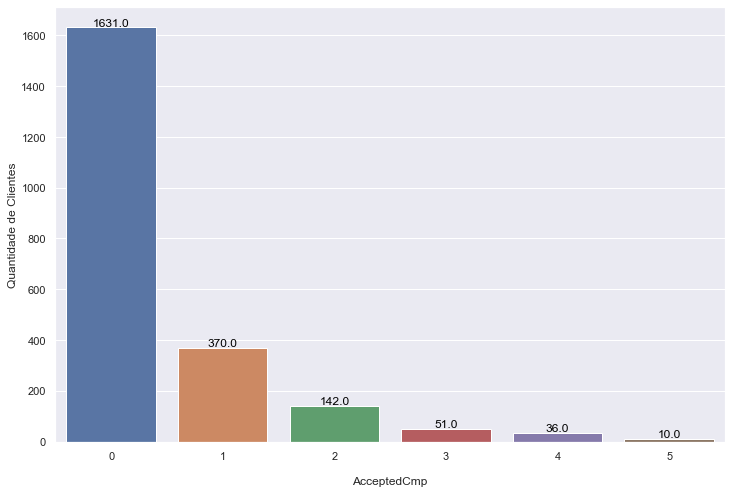

In [62]:
plot_cat(promotion, 'AcceptedCmp')

In [63]:
promotion = promotion[['ID', 'AcceptedCmp']]

#### Visão geral das variáveis relacionadas aos clientes

In [64]:
promotion.head()

,ID,AcceptedCmp
0,5524,1
1,2174,0
2,4141,0
3,6182,0
4,5324,0


### Dados de local de compra

Criando a coluna nova `TotalPurchases`, que corresponde à soma das variáveis `NumWebPurchases`, `NumCatalogPurchases` e `NumStorePurchases`.

#### TotalPurchases *

Juntando colunas correspondentes às compras dos clientes em `TotalPurchases`.

Obs: as colunas `NumDealsPurchases` (descontos) e `NumWebVisitsMonth`(visitas web) foram deixadas de fora.

In [65]:
place['TotalPurchases'] = place.NumWebPurchases + \
    place.NumCatalogPurchases + place.NumStorePurchases

Checando a distribuição.

In [66]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,4.084821,2.662054,5.790179,2.325000,5.316518,12.537054
std,3246.662198,2.778714,2.923101,3.250958,1.932238,2.426645,7.205741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2828.250000,2.000000,0.000000,3.000000,1.000000,3.000000,6.000000
50%,5458.500000,4.000000,2.000000,5.000000,2.000000,6.000000,12.000000
75%,8427.750000,6.000000,4.000000,8.000000,3.000000,7.000000,18.000000
max,11191.000000,27.000000,28.000000,13.000000,15.000000,20.000000,32.000000


É possível analisar que as colunas de compras são = 0, porém, há dados de desconto (`NumDealsPurchases`) em compras. Por esse motivo e por serem pouco numerosas, as linhas serão excluídas.

In [69]:
place[place['TotalPurchases'] == 0]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
655,5555,0,0,0,0,0,0
981,3955,0,0,0,0,14,0
1245,6862,0,0,0,15,20,0
1524,11110,0,0,0,0,14,0
1846,9931,0,0,0,15,19,0
2132,11181,0,0,0,0,0,0


In [70]:
place = place[place['TotalPurchases'] > 0]

Transformando as colunas em porcentagem.

In [71]:
place['NumWebPurchases'] = place['NumWebPurchases']/place['TotalPurchases']
place['NumCatalogPurchases'] = place['NumCatalogPurchases'] / \
    place['TotalPurchases']
place['NumStorePurchases'] = place['NumStorePurchases']/place['TotalPurchases']
place['NumDealsPurchases'] = place['NumDealsPurchases']/place['TotalPurchases']

Verificando se há porcentagens acima de 100% (>1).

In [72]:
place.describe()

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,5585.427037,0.329874,0.164809,0.505317,0.247963,5.300806,12.570725
std,3245.168172,0.121858,0.140668,0.149485,0.356679,2.372957,7.186011
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2817.750000,0.250000,0.000000,0.401852,0.083333,3.000000,6.000000
50%,5453.500000,0.333333,0.150000,0.500000,0.200000,6.000000,12.000000
75%,8419.500000,0.400000,0.250000,0.600000,0.333333,7.000000,18.000000
max,11191.000000,1.000000,1.000000,1.000000,15.000000,20.000000,32.000000


In [73]:
place[place.NumDealsPurchases > 1]

,ID,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,TotalPurchases
1042,10749,0.0,1.0,0.0,15.0,19,1


In [75]:
place = place[place['NumDealsPurchases'] <= 1]

#### NumWebVisitsMont

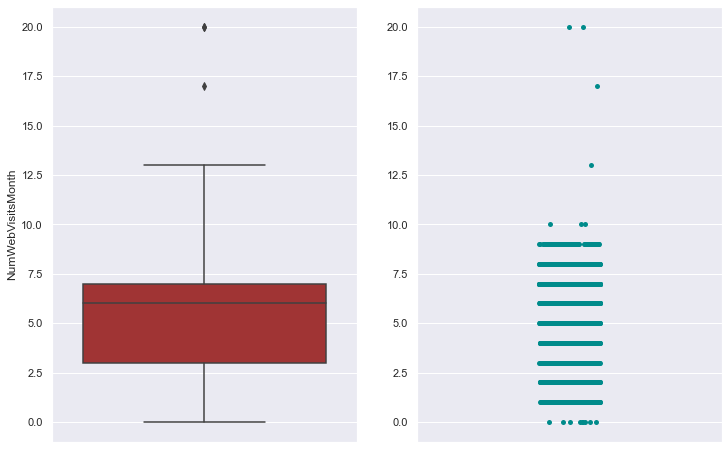

In [76]:
plot_num(place, 'NumWebVisitsMonth')

Verificou-se a presença de outliers, no entanto, pouco numerosos e como a variável representa o número de visitas web por mês, o cliente pode ser considerado de alto valor.

### Juntando os dados analisados e tratados

In [77]:
df_lista = [people, products, promotion, place]

In [78]:
df_final = reduce(lambda df1, df2: pd.merge(df1, df2, on='ID'), df_lista)

In [81]:
df_final.drop(columns=['ID'], inplace=True)

In [82]:
df_final.shape

(2203, 24)

In [83]:
df_final.columns

Index(['Year_Birth', 'Education', 'Income', 'Recency',
       'Marital_Status_Divorced', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'ChildrenHome',
       'LifeTime', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'TotalAmountSpent', 'AcceptedCmp', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'TotalPurchases'],
      dtype='object')

# Data Preparation